# Train and Test RF-model

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score #new
from sklearn import tree
from sklearn import metrics
import pydot
import seaborn as sns

In [2]:
# set plotting default parameters
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.figsize'] = (6.4, 4.8) # if wider plot, only change first value.
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana']
#plt.rcParams['ytick.major.pad']= 2

In [3]:
path_to_raw_data = '/data/wsd03/data_manuela/Illgraben/miniseed/'
file_ending = 'RF_v4_bigsf_clf2'

In [4]:
# List of attributes we want to use for classification
attribute_names = ['duration', 'RappMaxMean','RappMaxMedian', 'AsDec', 'KurtoSig', \
                    'KurtoEnv', 'SkewnessSig', 'SkewnessEnv', 'CorPeakNumber', 'INT1', \
                    'INT2', 'INT_RATIO', 'ES[0]', 'ES[1]', 'ES[2]', 'ES[3]', 'ES[4]', 'KurtoF[0]', \
                    'KurtoF[1]', 'KurtoF[2]', 'KurtoF[3]', 'KurtoF[4]', 'DistDecAmpEnv', \
                    'env_max/duration(Data,sps)', 'MeanFFT', 'MaxFFT', 'FmaxFFT', \
                    'FCentroid', 'Fquart1', 'Fquart3', 'MedianFFT', 'VarFFT', 'NpeakFFT', \
                    'MeanPeaksFFT', 'E1FFT', 'E2FFT', 'E3FFT', 'E4FFT', 'gamma1', 'gamma2', \
                    'gammas', 'SpecKurtoMaxEnv', 'SpecKurtoMedianEnv', 'RATIOENVSPECMAXMEAN', \
                    'RATIOENVSPECMAXMEDIAN', 'DISTMAXMEAN', 'DISTMAXMEDIAN', 'NBRPEAKMAX', \
                    'NBRPEAKMEAN', 'NBRPEAKMEDIAN', 'RATIONBRPEAKMAXMEAN', \
                    'RATIONBRPEAKMAXMED', 'NBRPEAKFREQCENTER', 'NBRPEAKFREQMAX', \
                    'RATIONBRFREQPEAKS', 'DISTQ2Q1', 'DISTQ3Q2', 'DISTQ3Q1']

In [10]:
# Read train and test feautre file
#catalog = pd.read_csv(path_to_raw_data[:-9] + 'feature_files/train_features_yfilt_40s_hSNR_v4_with_thunder.csv')
catalog = pd.read_csv(path_to_raw_data[:-9] + 'feature_files/train_features_yfilt_40s_hSNR_v4_with_thunder_without_bigsf.csv')
catalog_test = pd.read_csv(path_to_raw_data[:-9] + 'feature_files/test_features_yfilt_40s_hSNR_v4_with_thunder.csv')

def combine_classes_catalog_2(cat):
    cat.loc[cat['event_class'] == 2, 'event_class'] = 0 # Earthqauke Illgraben to Noise
    return cat

catalog = combine_classes_catalog_2(catalog)
catalog_test = combine_classes_catalog_2(catalog_test)
print(np.shape(catalog))
catalog.head()

(620, 61)


,event_idx,slice_idx,event_class,duration,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewnessSig,...,NBRPEAKMEAN,NBRPEAKMEDIAN,RATIONBRPEAKMAXMEAN,RATIONBRPEAKMAXMED,NBRPEAKFREQCENTER,NBRPEAKFREQMAX,RATIONBRFREQPEAKS,DISTQ2Q1,DISTQ3Q2,DISTQ3Q1
0,0,0,0,40.01,11.621308,13.382875,0.000000,29.192959,58.224163,0.654186,...,0,0,0.000000,0.000000,43,23,0.534884,5.813852,5.007588,10.821439
1,0,1,0,40.01,12.989940,41.775964,4.243775,24.769869,18.235417,0.617135,...,3,9,1.333333,0.444444,43,16,0.372093,4.841585,4.302575,9.144160
2,2,0,0,40.01,8.805683,13.153355,9.232737,12.392325,12.534898,0.263876,...,0,2,0.000000,0.000000,45,10,0.222222,4.941336,5.119590,10.060926
3,2,1,0,40.01,5.517401,8.359824,1.366056,5.482842,4.470063,0.100531,...,5,22,1.600000,0.363636,51,9,0.176471,4.576330,4.914586,9.490916
4,2,2,0,40.01,4.076638,4.514342,92.046512,3.746714,3.910707,0.047172,...,7,53,1.142857,0.150943,45,27,0.600000,4.473828,4.226824,8.700652


In [11]:
gr_train = catalog.groupby('event_idx').first() # takes only first timewindow from event
gr_test = catalog_test.groupby('event_idx').first() # takes only first timewindow from event
gr_test[gr_test['event_class'] == 1]

,slice_idx,event_class,duration,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewnessSig,SkewnessEnv,...,NBRPEAKMEAN,NBRPEAKMEDIAN,RATIONBRPEAKMAXMEAN,RATIONBRPEAKMAXMED,NBRPEAKFREQCENTER,NBRPEAKFREQMAX,RATIONBRFREQPEAKS,DISTQ2Q1,DISTQ3Q2,DISTQ3Q1
event_idx,,,,,,,,,,,,,,,,,,,,,
17,0,1,40.01,3.596649,3.894292,0.035455,3.132553,3.944306,0.007406,0.831002,...,3,14,2.000000,0.428571,21,33,1.571429,4.245574,4.105572,8.351146
20,0,1,40.01,9.632125,29.351504,4.857980,12.222148,9.015058,0.200590,2.326823,...,1,9,3.000000,0.333333,23,9,0.391304,4.415077,4.968837,9.383914
24,0,1,40.01,7.936242,39.820574,4.549237,11.392583,7.632915,0.085739,2.092004,...,3,8,1.000000,0.375000,40,22,0.550000,3.878818,3.616063,7.494881
25,0,1,40.01,6.030819,7.589484,17.872642,6.582485,9.183023,0.034780,2.072771,...,0,2,0.000000,0.000000,25,22,0.880000,4.819584,3.897068,8.716653
26,0,1,40.01,8.148813,34.018740,10.497126,10.511834,7.006029,0.144457,1.963308,...,2,8,1.500000,0.375000,35,33,0.942857,3.442060,3.130805,6.572865
27,0,1,40.01,3.352804,3.605667,1.795947,3.221219,3.831803,0.040959,0.853840,...,9,48,1.111111,0.208333,33,31,0.939394,6.196108,4.830335,11.026443
29,0,1,40.01,9.378785,25.950413,0.000000,13.723142,9.579943,0.507181,2.516687,...,0,0,0.000000,0.000000,49,16,0.326531,5.281842,4.585080,9.866923
52,0,1,40.01,7.347712,9.820201,1.357690,9.156820,11.795604,0.326415,2.592355,...,2,15,1.000000,0.133333,16,7,0.437500,4.370576,4.763583,9.134160
61,0,1,40.01,5.355649,7.201601,0.684632,6.299165,6.442957,0.074038,1.752272,...,1,12,5.000000,0.416667,28,17,0.607143,4.482328,4.785084,9.267412


In [12]:
# take all attributes
X_train = np.asarray(catalog[attribute_names])
y_train = np.asarray(catalog['event_class'])
X_test = np.asarray(catalog_test[attribute_names])
y_test = np.asarray(catalog_test['event_class'])

print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

#print(len(catalog['event_class']==1))
#print(np.where(catalog['event_class']==1))
#print(np.shape(np.where(y_test==1)))
#print(np.shape(np.where(y_train==1)))

(620, 58)
(620,)
(263, 58)
(263,)


In [9]:
## take features with importance 0.005 or bigger
## get feature importance
#importances = clf.feature_importances_
#importances.sort()
#importances
##print(sum(clf.feature_importances_))
#df_imp = pd.DataFrame({'imp': clf.feature_importances_, 'label': attribute_names}).sort_values(by='imp', ascending=False)
#
## drop features with an importance smaller than 0.005
#indexNames = df_imp[df_imp['imp'] < 0.0025].index
#df_imp.drop(indexNames , inplace=True)
#imp_list = df_imp['label'].to_list()
#imp_list
#
#X_train = np.asarray(catalog[imp_list])
#y_train = np.asarray(catalog['event_class'])
#X_test = np.asarray(catalog_test[imp_list])
#y_test = np.asarray(catalog_test['event_class'])
#
#print(np.shape(X_train))
#print(np.shape(y_train))
#print(np.shape(X_test))
#print(np.shape(y_test))
#
## Fit model
#clf.fit(X_train, y_train)
## Predict test data set
#y_pred = clf.predict(X_test)
## Get probabilities
#probas = clf.predict_proba(X_test)  
## Print confision matrix
#print(confusion_matrix(y_test, y_pred))

## Train the RF

In [9]:
# load model
filename = '../model/{}.model'.format(file_ending)
clf = pickle.load(open(filename, 'rb'))
clf

BalancedRandomForestClassifier(max_depth=10, max_features='sqrt',
                               min_samples_split=20, n_estimators=1200,
                               n_jobs=-1, random_state=10,
                               sampling_strategy='majority')

In [10]:
# Train balanced random forest classifier
clf = BalancedRandomForestClassifier(n_estimators=1200,criterion='gini',sampling_strategy='majority', max_features='sqrt', \
                                     n_jobs=-1, min_samples_leaf = 1, max_depth=10, min_samples_split=20, \
                                     oob_score=False, bootstrap=True, class_weight=None,random_state=10)

[[193  17]
 [  3  50]]


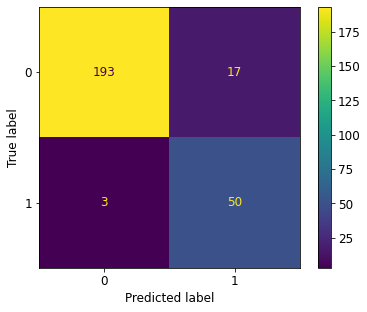

In [22]:
# Fit model
clf.fit(X_train, y_train)
# Predict test data set
y_pred = clf.predict(X_test)
# Get probabilities
probas = clf.predict_proba(X_test)  
# Print confision matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

## Plot and calculate statistical values for the RF

In [15]:
round((balanced_accuracy_score(y_test, y_pred)),3)

0.931

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana


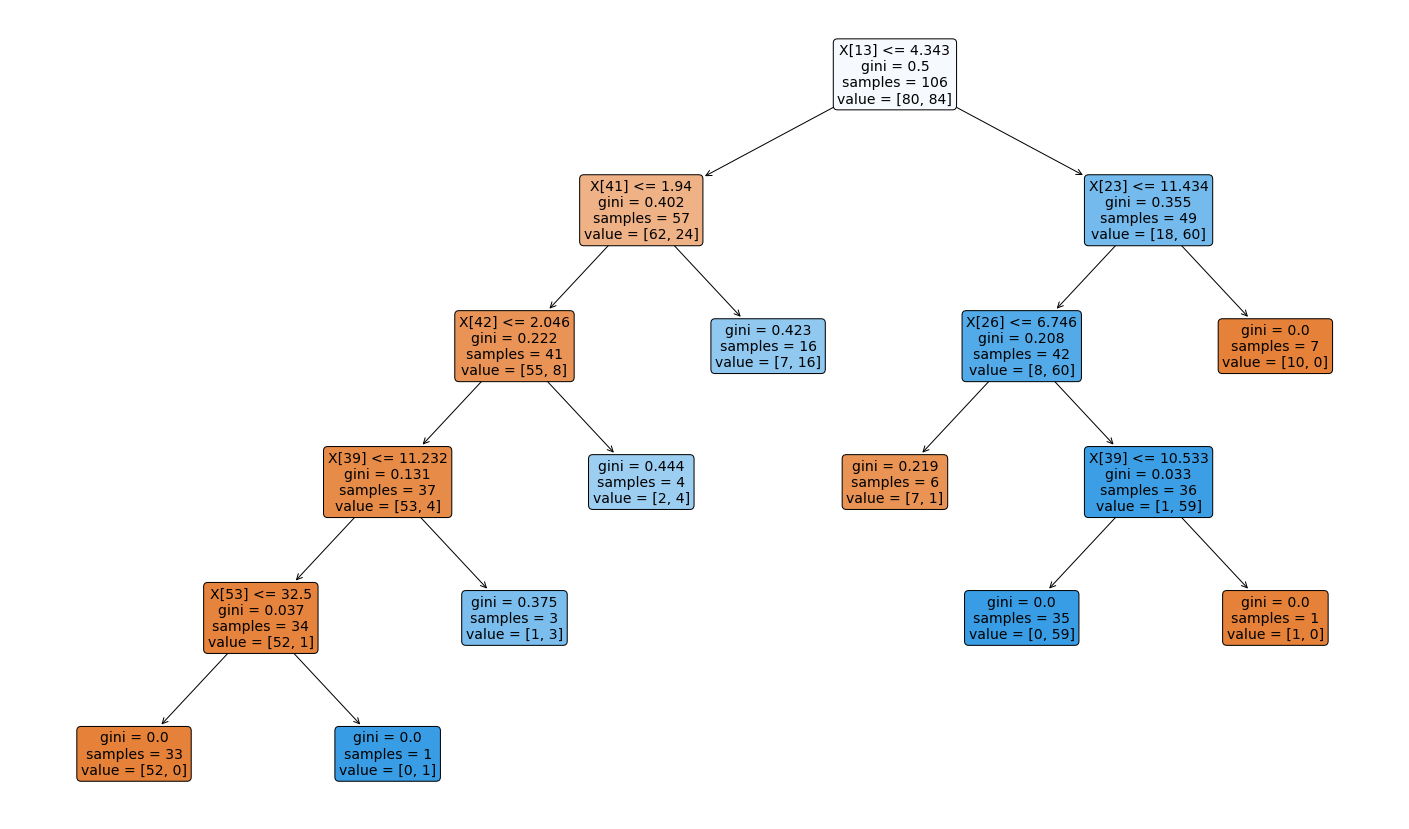

In [16]:
# Pull out one tree from the forest
Tree = clf.estimators_[999]
# Export the image to a dot file
plt.figure(figsize=(25,15))
tree.plot_tree(Tree,filled=True, 
              rounded=True, 
              fontsize=14);

In [17]:
importances = clf.feature_importances_
importances.sort()
importances

print(sum(clf.feature_importances_))
pd.DataFrame({'imp': clf.feature_importances_, 'label': attribute_names}).sort_values(by='imp', ascending=False)

1.0000000000000002


,imp,label
28,0.072274,Fquart1
26,0.064082,FmaxFFT
17,0.060845,KurtoF[0]
38,0.046856,gamma1
39,0.044587,gamma2
18,0.037998,KurtoF[1]
15,0.037780,ES[3]
14,0.036624,ES[2]
10,0.031511,INT2
4,0.031147,KurtoSig


/home/koepflma/anaconda3/envs/ILLenv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


([<matplotlib.axis.YTick at 0x7fba89f517b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana


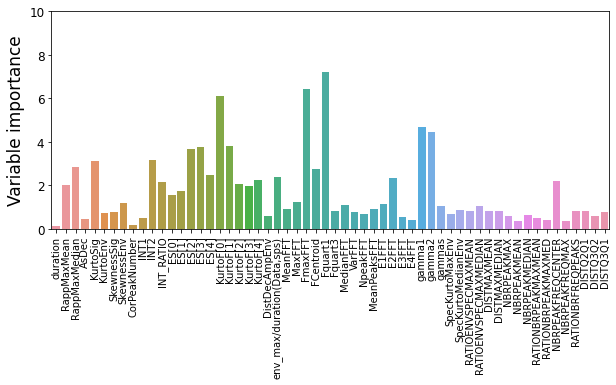

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
sns.barplot(attribute_names,clf.feature_importances_*100)

plt.ylabel('Variable importance',fontsize=17)
#.xlabel('Variable',fontsize=10)
plt.xticks(rotation=90,fontsize=10)
plt.yticks(np.linspace(0,10,6))
#plt.savefig(f'../plot/feature_importance_{plot_ending}.png',bbox_inches='tight', dpi=300)

<AxesSubplot:>

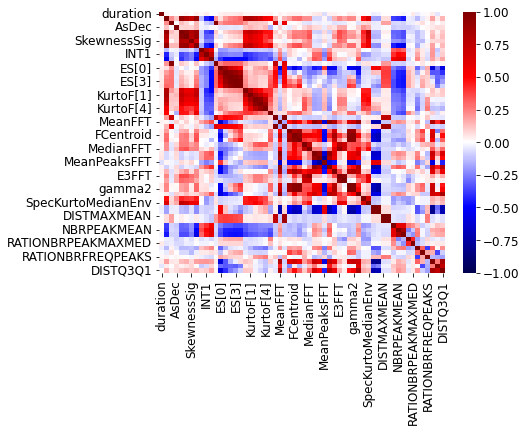

In [19]:
#Heat map of feature correlation
df_corr = pd.DataFrame(X_train, columns = attribute_names)
corr = df_corr.corr()
sns.heatmap(corr,cmap='seismic',vmin=-1, vmax=1)
#plt.savefig(f'../plot/feature_correlation_{plot_ending}.png',bbox_inches='tight', dpi=300)
#corr>0.9
#corr.where(corr>0.9)

## ROC & AUC

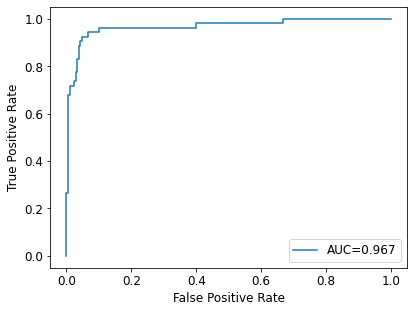

In [30]:
#define metrics
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = round(metrics.roc_auc_score(y_test, y_pred_proba),3)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Pairplot

In [5]:
# Read feature file
file_ending = 'beginning_2017'
df = pd.read_csv('../catalog/combined_classes_catalog_{}'.format(file_ending))
print(file_ending)
print(np.shape(df))

beginning_2017
(5176, 61)


In [6]:
df

,event_idx,slice_idx,event_class,duration,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewnessSig,...,NBRPEAKMEAN,NBRPEAKMEDIAN,RATIONBRPEAKMAXMEAN,RATIONBRPEAKMAXMED,NBRPEAKFREQCENTER,NBRPEAKFREQMAX,RATIONBRFREQPEAKS,DISTQ2Q1,DISTQ3Q2,DISTQ3Q1
0,0.0,0.0,0.0,40.01,20.569099,45.413096,265.733333,43.558720,28.134153,0.342472,...,0.0,0.0,0.000000,0.000000,15.0,24.0,1.600000,18.446573,15.723525,34.170098
1,0.0,1.0,0.0,40.01,12.507184,31.865396,2.042586,21.645753,15.873836,0.250515,...,1.0,3.0,3.000000,1.000000,18.0,33.0,1.833333,19.264337,12.734723,31.999060
2,1.0,0.0,0.0,40.00,5.286637,5.848421,49.632911,9.172503,19.521486,0.146934,...,0.0,3.0,0.000000,0.000000,44.0,41.0,0.931818,21.559377,17.233302,38.792679
3,1.0,1.0,0.0,40.00,7.427659,9.961383,8.029345,8.137521,11.242831,0.077474,...,3.0,10.0,1.000000,0.300000,14.0,26.0,1.857143,16.990547,15.100264,32.090812
4,1.0,2.0,0.0,40.00,6.660431,8.490721,1.294894,6.656690,9.432106,0.113646,...,4.0,15.0,0.750000,0.200000,1.0,9.0,9.000000,10.513434,13.846492,24.359926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5171,333.0,0.0,0.0,40.01,3.441553,3.578573,0.415281,4.025727,5.867156,0.013107,...,7.0,28.0,1.714286,0.428571,18.0,23.0,1.277778,16.171783,13.783741,29.955524
5172,334.0,0.0,0.0,40.01,3.069524,3.169933,0.026161,3.481105,4.972838,0.005792,...,9.0,23.0,2.666667,1.043478,64.0,10.0,0.156250,16.656041,14.615006,31.271047
5173,335.0,0.0,0.0,40.01,3.931884,4.178080,0.025897,5.434915,7.876373,0.007880,...,1.0,2.0,2.000000,1.000000,26.0,9.0,0.346154,15.497021,14.310750,29.807772
5174,336.0,0.0,0.0,40.01,3.406601,3.425518,1.075207,4.112643,4.252655,0.038014,...,6.0,28.0,4.833333,1.035714,20.0,4.0,0.200000,18.049816,22.381892,40.431708


In [ ]:
sns.pairplot(df, hue="event_class")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
